# **Value-at-Risk:**



What risk is my portfolio under? What is the most I can lose? These are questions investors are/should constantly ask themselves (at least when they take a break).

### what is value-at-risk?
It measures the potential loss of a single asset or a portfolio (several assets) given a period of time and a confidence interval. In brief, it shoudl answer the question: what could be my maximum loss with 95% of confidence?
It is sometimes defined as the the possible loss in value resulting from 'normal market risk'.

There are 3 main approaches to compute value-at-risk (with some variation within each):


1.   variance-covariance method
2.   historical data
3.   Monte-Carlo simulations

Let's first dive into these 3 methods before introducing a new risk metric using Gaussian Mixture Models.



## **Build the portfolio:**

In [ ]:
!pip install yfinance
import yfinance as yf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


     |████████████████████████████████| 5.5MB 6.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=142660e6e4dec66803c794052e64e03d29b93c35b7c2758d9a9c81f3e9d8f21e
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
tickers = ['AMD', 'NFLX', 'NKE']

data = yf.download(tickers, period='5y', auto_adjust=True)


[*********************100%***********************]  3 of 3 completed


In [ ]:
data

Close                          ...    Volume                    
                  AMD        NFLX         NKE  ...       AMD      NFLX       NKE
Date                                           ...                              
2015-11-13   1.990000  103.650002   57.269287  ...   5920200  18819400  16371000
2015-11-16   1.990000  111.349998   58.021221  ...   4149700  19866200   9146400
2015-11-17   1.980000  117.099998   57.607655  ...   5825100  33016300  10581600
2015-11-18   2.120000  120.629997   59.111519  ...   9384700  23353600  10597800
2015-11-19   2.140000  120.220001   59.111519  ...   4704300  19253200   8557600
...               ...         ...         ...  ...       ...       ...       ...
2020-11-06  85.879997  514.729980  128.899994  ...  53829900   4236300   2954000
2020-11-09  83.120003  470.500000  128.949997  ...  58580700  10419700   7491700
2020-11-10  77.989998  480.239990  127.709999  ...  67137200   8306100   8014700
2020-11-11  81.279999  490.760010  127.660004  ...  44611300   5460500   6058700
2020-11-12  81.839996  486.769989  126.639999  ...  37242600   5063700   4780400

[1259 rows x 15 columns]

In [ ]:
nb_days = 1
portfolio = pd.DataFrame()
portfolio['Returns'] = data['Close'].pct_change(nb_days).dropna().sum(axis=1)

In [ ]:
portfolio

,Returns
Date,
2015-11-16,0.087418
2015-11-17,0.039486
2015-11-18,0.126957
2015-11-19,0.006035
2015-11-20,0.122114
...,...
2020-11-06,0.030419
2020-11-09,-0.117678
2020-11-10,-0.050633


In [ ]:
portfolio_value = 1e6

## **Traditional methods to estimate risk:**

### **Variance-covariance Method:**



Since VAR measures the probability that the value will drop below a specific value over a period of time, it makes sense to derive this probability from the probability distribution of potential values.
When working with portfolios of assets, the same idea will apply but the process of estimating parameters is complicated because of the assets movement within the porfolio.

This method consist in a 2 steps process:


1.   Estimate variances and covariances of each of these instruments. In other words getting the correlation matrix of the portfolio of assets.
2.   Compute the value-at-risk using the weights on the standardized instruents of the portfolio as well as the correlation matrix.


This method is making an asumption about how returns are distributed. Each market risk factor has normally distributed retruns as well as the returns of any portfolios.
  
####**Note:** 
Returns on individual risk factors are assumed to follow conditional normal distribution. While returns may not themselves be normally distributed and large outliers are very common (fat tails in the distribution), the assumption is that the standardized return (computed as the return divided by the forecasted standard deviation) is normally distributed.Hence, a large return (positive or negative) in a period of high volatility may result in a low standardized return, whereas the same return following a period of low volatility will yield an abnormally high standardized return.

#### **PROS:**


*   Simple to compute

#### **CONS:**


*   Wrong distributional assumption
*   Input error directly from the correlation matrix (id, variances & covariances).
*   Non-Stationary variables: correlation between will most like ly change over time.

The two last issue are the main ones.we get much better estimates by using models that explicitly allow the standard deviation to change of time (heteroskedasticity).6 In fact, he suggests two variants – Autoregressive Conditional Heteroskedasticity (ARCH) and Generalized Autoregressive Conditional Heteroskedasticity (GARCH) – that provide better forecasts of variance and, by extension, better measures of Value at Risk. 
The first issue can be dealt with by giving the choice of the distribution to the user or assume that it falls a multivariate normal distribution.


In [ ]:
returns = data['Close'].pct_change(1).dropna()
cov = returns.cov()

In [ ]:
portfolio_value = 1e6
weights = np.ones(len(cov))/len(cov) # equally weighted portfolio
portfolio_mean = (1+portfolio['Returns'].mean())*portfolio_value
portfolio_std = np.sqrt(weights.T.dot(cov).dot(weights))*portfolio_value


In [ ]:
from scipy.stats import norm
CV_VaR = portfolio_value - norm.ppf(0.95, portfolio_mean, portfolio_std)
print(f'The Covariance-Variance VaR is {CV_VaR}')

The Covariance-Variance VaR is -50842.95174418646


### **Historical Simulation Method:**

This is the easiest wayof estimating value-at-risk for many portfolios. Here, the method consists in estimating the VAR by creating hypotheticaltime series of returns on that portfolio. 

To perform historical simulation, we start with time series data on each market risk factor.The historical changes yield for all the information needed to compute the VaR.

#### **Idea:**
organized daily price changes into positive and negative numbers and analyzed each group.
With a 99% confidence interval, the positive VaR is defined as the price change in the 99th percentile of the positive price changes and the negative VaR as the price change at the 99th percentile of the negative price changes.

#### **Assumption:**

*   The approach is agnostic when it comes to distributional assumptions, and the VaR is determined by the actual price movements.
*   Each day in the time series carries an equal weight when it comes to measuring the VaR, a potential problem if there is a trend in the variability.
*   The approach is based on the assumption of history repeating itself. In other words, it is period dependant. For instance,a peak volatility (black swan event) may skew the end results of the VaR.

#### **Pros:**

* Very simple.
* Independent of the distribution.

#### **Cons:**

* The historical simulation approach has the most difficulty dealing with new risks and assets for an obvious reason: there is no historic data available to compute the Value at Risk.
* To the extent that there is a trend of increasing volatility even within the historical time period, we will understate the Value at Risk as all data points are weighted equally.

#### **Possible modification:**(already proposed)

* Each return, rather than being weighted
equally, is assigned a probability weight based on its recency. 
* We could fit the historical data to a forcasting model (ARMA etc ...) and use the model parameter to compute the VaR.


##### **Historical VaR python code:** *italicized text*

In [ ]:
import scipy.stats as stats

Annual Mean of Returns: 0.014%
Annual Variance of Returns: 0.134%
The simple historical VaR is -225063.20403753256


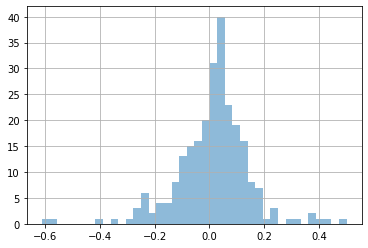

In [ ]:
portfolio['Returns'].hist(bins=40, histtype='stepfilled', alpha=0.5 )

mu = np.mean(portfolio['Returns'])
sigma = np.std(portfolio['Returns'])
print(f"Annual Mean of Returns: {mu:0.3f}%")
print(f"Annual Variance of Returns: {sigma:0.3f}%")

VaR = np.percentile(portfolio['Returns'], 5, interpolation="lower")*portfolio_value
print(f'The simple historical VaR is {VaR}')




##### **Conditional VaR python code:**

In [ ]:
CVaR = portfolio['Returns'][ portfolio['Returns'] <= np.percentile(portfolio['Returns'], 5, interpolation="lower")].mean()*portfolio_value
print(f'The conditional historical VaR is {CVaR}')

The conditional historical VaR is -317971.96570964414


If you consider implementing the impovement using the arima model, it is very to work on finding the right order (p,d,q) before hand. Otherwise the fiting on the model will be completely wrong.

### **Monte-Carlo simulation method:**

In this method, we specify probability distributions for each of the market risk factors and specify how these market risk factors move together. While the estimation of parameters is easier if you assume normal distributions for all variables, the power of Monte Carlo simulations comes from the freedom you have to pick alternate distributions for the variables. In addition, you can bring in subjective judgments to modify these distributions.

Once the distributions are specified, the simulation process starts. In each run, the
market risk variables take on different outcomes and the value of the portfolio reflects the outcomes. After a repeated series of runs, numbering usually in the thousands, you will have a distribution of portfolio values that can be used to assess Value at Risk. For instance, assume that you run a series of 10,000 simulations and derive corresponding values for the portfolio. These values can be ranked from highest to lowest, and the 95% percentile Value at Risk will correspond to the 500th lowest value and the 99th percentile to the 100th lowest value.

#### **Pros:**

The strengths of Monte Carlo simulations can be seen when compared to the other two approaches for computing Value at Risk. Unlike the variance-covariance approach, we do not have to make unrealistic assumptions about normality in returns. In contrast to the historical simulation approach, we begin with historical data but are free to bring in both subjective judgments and other information to improve forecasted probability distributions. Finally, Monte Carlo simulations can be used to assess the Value at Risk for any type of portfolio and are flexible enough to cover options and option-like securities.

#### **Cons:**

First, you now have to estimate the probability distributions for hundreds of market risk variables rather than just the handful that we talked about in the context of analyzing a single project or asset. Second, the number of simulations that you need to run to obtain reasonable estimate of Value at Risk will have to increase substantially (to the tens of thousands from the thousands).

#### **Possible modification:**(already proposed)

Use the variance-covariance method with the monte-carlo simulation.


In [ ]:
mu_portfolio = np.mean(portfolio['Returns'])
sigma_portfolio = np.std(portfolio['Returns'])
T = 252
sim_returns = []
for i in range(1000):
  rand_rets = np.random.normal(mu_portfolio, sigma_portfolio, T)
  sim_returns.append(rand_rets)
  
var_MC = np.percentile(sim_returns, 5)*portfolio_value
print(f'The Monte-Carlo VaR is {var_MC}')

The Monte-Carlo VaR is -204901.56888654802


### **Conclusion:**

Monte-Carlo and historical VaR have approximatively are rather close compare to covariance-variance VaR. i believe this due to strong assumption about the normal distribution of the portfolio returns.


Skew is -0.5449376030929813
Kurtosis is 3.900695917466848


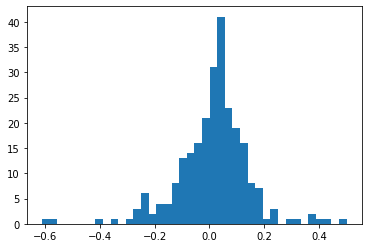

In [ ]:
from scipy.stats import kurtosis, skew
print(f"Skew is {skew(portfolio['Returns'])}")
print(f"Kurtosis is {kurtosis(portfolio['Returns'])}")
plt.hist(portfolio['Returns'], bins=40, density=None)
plt.show()

As we can see the kurtosis is high which yields against the hypotesis of normal distribution. I believe It is the monte-carlo method is less impacted thanks to the large number of scenario used.

## **Estimating level of risk using GMM:**

As we'seen traditional methods have many issues : 
* time varying mean
* time varying volatility

Let's investigate.

#### **GMM:**

First of all, GMM gives a local solution (for the parameters $\mu$ and $\Sigma$) thanks to the EM algorithm emebeded in the clustering process of GMM.Thus, the best way to use GMM is to aply it by period (window of the time series).

Here are some benefits of using GMM:
* corrupted data don't change much the final result
* Missing data are not a problem either


I am not going to tackles the GMM algortihm and neither the expectation-maximisation on which it relies.


We will assume an equally weighted portfolio for the time being.


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import TimeSeriesSplit
from IPython.display import display


In [ ]:
# Creat the the Gaussian mixture model object
# n_components = number of risk level we would like 
# max_iter = the number of iteration done by the EM algorithm
# n_init = number of initialization to do before taking the best one for the EM algorithm
def perform_gmm(n_components, max_iteration=200, n_init=150, random_state = 10):
  args = dict(random_state = random_state,
              n_components = n_components,
              max_iter = max_iter,
              n_init = n_init )
  gmm = GaussianMixture(**args)


##### **Portfolio Returns:**(construction and analysis)

In [ ]:
def compute_daily_change(df):
  port_returns = pd.DataFrame()
  # Compute time series of daily returns for each stock of the portfolio and for the whole portfolio
  port_returns = df['Close'].pct_change(1).dropna()
  port_returns['Portfolio Returns'] = data['Close'].pct_change(1).dropna().sum(axis=1)

  return port_returns
  

In [ ]:
port_change = compute_daily_change(data)
port_change

,AMD,NFLX,NKE,Portfolio Returns
Date,,,,
2015-11-16,0.000000,0.074288,0.013130,0.087418
2015-11-17,-0.005025,0.051639,-0.007128,0.039486
2015-11-18,0.070707,0.030145,0.026105,0.126957
2015-11-19,0.009434,-0.003399,0.000000,0.006035
2015-11-20,0.037383,0.030111,0.054619,0.122114
...,...,...,...,...
2020-11-06,0.034699,0.001888,-0.006168,0.030419
2020-11-09,-0.032138,-0.085929,0.000388,-0.117678
2020-11-10,-0.061718,0.020701,-0.009616,-0.050633


I believe 5 years of data is enough for the algorithm to work well.

Before anything let's look at the returns distribution for each stocks as well as for the portfolio.

In [ ]:
import plotnine as pn

In [ ]:
def plot_distributions(df):
  p = (pn.ggplot(pd.melt(df), pn.aes(x='value', color='variable'))
     +pn.geom_density(pn.aes(fill='variable'), alpha=0.5))
  p.draw();

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


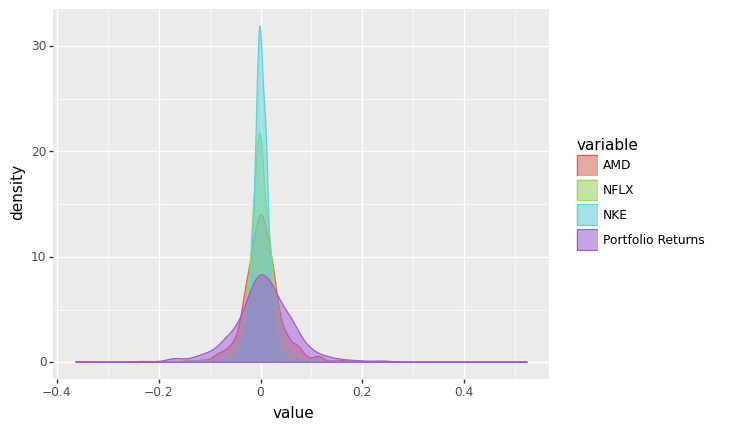

In [ ]:
plot_distributions(port_change)

We can clearly see the fat tails of the portfolio returns distribution.

##### **Risk level clustering of the portfolio return:**(2 levels)

In [ ]:
def display_level(df, means, covariances):
    
    #Display parameters
    fig = plt.figure(figsize=(12,7))

    std_0 = np.std(df_states.loc[df_states['State']==0, 'Portfolio Returns'])
    std_1 = np.std(df_states.loc[df_states['State']==1, 'Portfolio Returns'])



    for i, (mean, covar) in enumerate(zip(means, covariances)):
        
        # select date and data to display for each state of the iteration
        x = df.loc[df['State']==i, 'Date']
        y = df.loc[df['State']==i, 'Portfolio Returns']

        # tackle color & state issue
        if std_0 < std_1 and i==0:
          color = 'green'
          label = 'level 0'
        elif std_0 < std_1 and i == 1:
          color = 'red'
          label = 'level 1'
        elif std_0 > std_1 and i==0:
          color = 'red'
          label = 'level 1'
        elif std_0 > std_1 and i == 1:
          color = 'green'
          label = 'level 0' 

        
        # Scater plot the poiint corresponding to the current sate of the iteration
        plt.scatter(x, y, 30, color=color, edgecolors='k', linewidths=0.5,label=label)
        plt.xlim(df['Date'].min(), df['Date'].max())
        plt.axhline(y=0, color='black', linestyle=':')
        plt.legend()

        # Title display
        min_idx_str = df['Date'].min().strftime('%Y/%m/%d')
        max_idx_str = df['Date'].max().strftime('%Y/%m/%d')
        title_text = f"Period ${min_idx_str}$ through ${max_idx_str}$"
        plt.title(title_text, fontsize=17, fontweight='medium')

    plt.show()

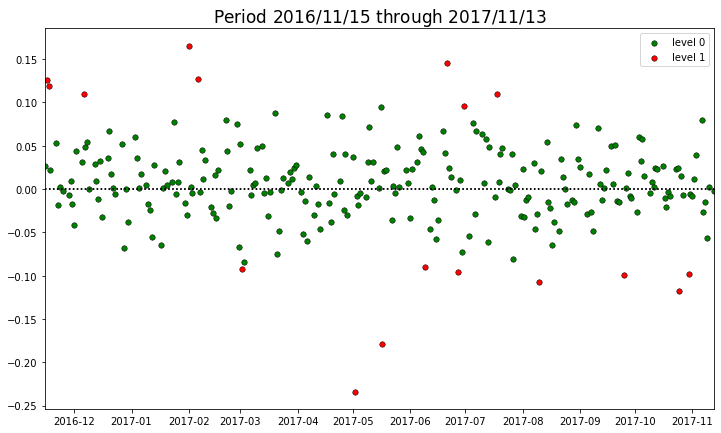

State                             0          1
Portfolio Returns count  234.000000  17.000000
                  mean     0.006499  -0.006765
                  std      0.035751   0.133371
                  min     -0.084416  -0.233755
                  25%     -0.014791  -0.099039
                  50%      0.004056  -0.090498
                  75%      0.029756   0.119566
                  max      0.094239   0.165736

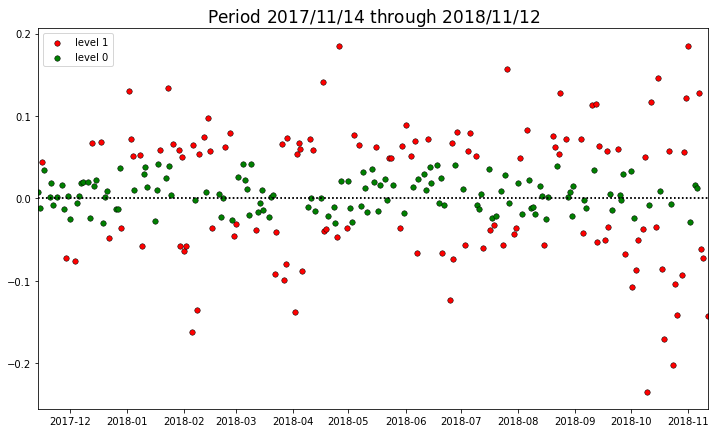

State                             0           1
Portfolio Returns count  122.000000  129.000000
                  mean     0.007424    0.005006
                  std      0.085995    0.019745
                  min     -0.234207   -0.030293
                  25%     -0.057324   -0.011344
                  50%      0.049753    0.004279
                  75%      0.067470    0.019625
                  max      0.185393    0.042057

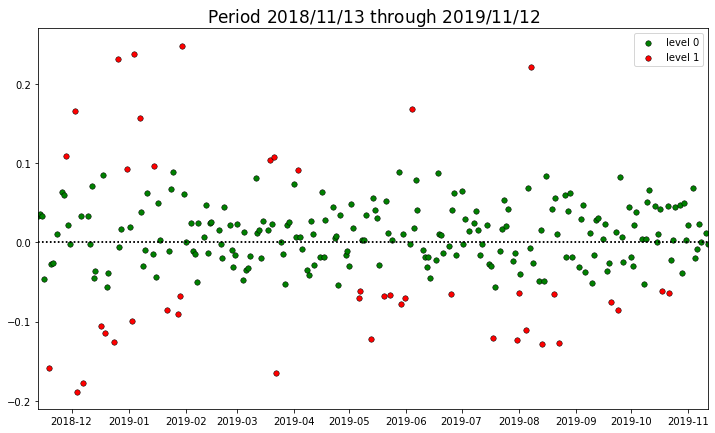

State                             0          1
Portfolio Returns count  208.000000  43.000000
                  mean     0.010033  -0.022676
                  std      0.035153   0.127366
                  min     -0.056197  -0.188389
                  25%     -0.017295  -0.112937
                  50%      0.010071  -0.068043
                  75%      0.034300   0.094080
                  max      0.088920   0.248450

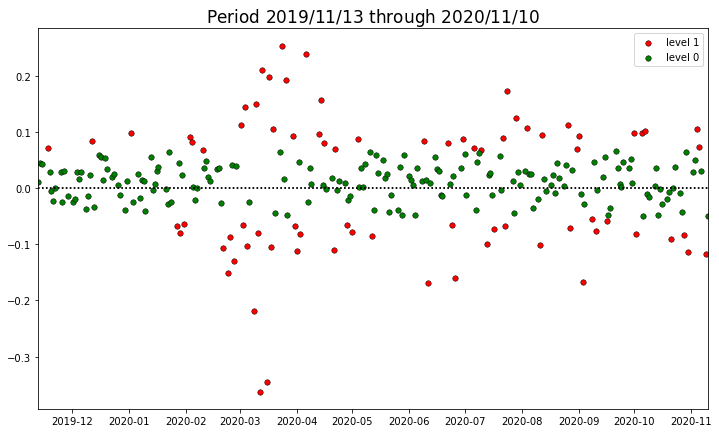

State                            0           1
Portfolio Returns count  77.000000  174.000000
                  mean    0.002352    0.010437
                  std     0.127073    0.030707
                  min    -0.362136   -0.050633
                  25%    -0.084635   -0.012242
                  50%     0.066897    0.013187
                  75%     0.096202    0.034561
                  max     0.253554    0.065923

In [ ]:
# initialize lists of information
pred_levels = []
pred_covariances = []
pred_means = []

# initialize parameters 
n_components = 2 
n_split = 4 # default value 
lookback = 252 # 1 trading year => display by year (to be reduce to 21 if you want by month)

tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)
gmm = GaussianMixture(n_components) 

for i, (train, test) in enumerate(tscv.split(port_returns['Portfolio Returns'])): 
    
    # Using the indexes returned to split the data into chunk
    tmp_train_set = port_returns['Portfolio Returns'].iloc[train] 
    tmp_test_set = port_returns['Portfolio Returns'].iloc[test] 
    X_train = tmp_train_set.values.reshape(-1,1) # format needed for gmm (sklearn function)
    X_test = tmp_test_set.values.reshape(-1,1)

    # Fit the GMM model for the dataset which expresses the dataset as a mixture of 2 Gaussian Distribution
    # covariance type is 'full' by defult, so, each component has its own general covariance matrix
    
    gmm.fit(X_train) 
    
    # predict hidden states
    states_proba= gmm.predict_proba(X_test)
    states = gmm.predict(X_test)

    # Update lists
    pred_levels.append(states)
    pred_means.append(gmm.means_)
    pred_covariances.append(gmm.covariances_) 

    # create dataframe states' info
    df_states = tmp_test_set.to_frame().assign(State = pd.Categorical(states)).reset_index()
    
    # display
    display_level(df_states, gmm.means_, gmm.covariances_)  
    display(df_states.groupby('State').describe().T)

 



The 2 risk regimes are well detected thanks to the GMM clustering. To my opinion, it is more visual than the VaR even though it doesn't give an exact value of the risk we are under. We are not constrained in term of risk level we would like, so, with a good calibration it could be very efficient. 
Also, a big advantage is that we don't need lot's of data to train the model.

##### **Estimate multivariate gaussian parameters:** (2 stoks)

Applying this method to the portfolio returns is not taking full advantage of the gaussian mixture model that can work in d dimension. 

In what is comming next we are going to evaluate the multivariate gaussian mixture that compose the portfolio.
To do so, we will feed the daily returns of 2 stocks and get 2 multivariate with respect to 2 compoenents. **I believe it is far fetch to think that each component is corresponding to a particular stock**.

Multivariate gaussians is a more realistic distribution assumption for the return of a given stock in a portfolio.

In [ ]:
X = port_change.iloc[:,:2]

# initialize lists of information
pred_levels = []
pred_covariances = []
pred_means = []

# initialize parameters 
n_components = 2 
n_split = 4 # default value 
lookback = 252 # 1 trading year => display by year (to be reduce to 21 if you want by month)

tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)
gmm = GaussianMixture(n_components) 

#x = np.stack((X.iloc[:,0],X.iloc[:,1]))

for i, (train, test) in enumerate(tscv.split(X)): 
    
    # Using the indexes returned to split the data into chunk
    tmp_train_set = X.iloc[train] 
    tmp_test_set = X.iloc[test] 

    # Fit the GMM model for the dataset which expresses the dataset as a mixture of 2 Gaussian Distribution
    # covariance type is 'full' by defult, so, each component has its own general covariance matrix  
    gmm.fit(tmp_train_set) 
    
    # predict hidden states
    states_proba= gmm.predict_proba(tmp_test_set)
    states = gmm.predict(tmp_test_set)

    
    # Update lists
    pred_levels.append(states)
    pred_means.append(gmm.means_)
    pred_covariances.append(gmm.covariances_) 


    # display
    print('')
    print('Parameters multivariate gaussian associate to component 0:')
    print('covariance matrix')
    print(gmm.covariances_[0])
    print('means')
    print(gmm.means_[0])
    print('')
    print('Parameters multivariate gaussian associate to component 1:')
    print('covariance matrix')
    print(gmm.covariances_[1])
    print('means')
    print(gmm.means_[1])
    print('')
    print('*'*70)
    

 


Parameters multivariate gaussian associate to component 0:
covariance matrix
[[0.02083336 0.00133264]
 [0.00133264 0.00600649]]
means
[ 0.03508842 -0.01573277]

Parameters multivariate gaussian associate to component 1:
covariance matrix
[[0.00146117 0.00018836]
 [0.00018836 0.00041542]]
means
[0.00458731 0.00151733]

**********************************************************************

Parameters multivariate gaussian associate to component 0:
covariance matrix
[[0.00110559 0.00013483]
 [0.00013483 0.0002924 ]]
means
[0.00478748 0.00260042]

Parameters multivariate gaussian associate to component 1:
covariance matrix
[[ 0.00473934 -0.00131976]
 [-0.00131976  0.0004455 ]]
means
[-0.1393487  -0.02131751]

**********************************************************************

Parameters multivariate gaussian associate to component 0:
covariance matrix
[[0.00337797 0.00081668]
 [0.00081668 0.0016063 ]]
means
[0.00471437 0.00025727]

Parameters multivariate gaussian associate to compon